
# Statistical Characterization of Bitcoin Order Book Volume

## Research Motivation and Intent

This notebook investigates the statistical properties of log-transformed average **ask volumes** in the BTC/USD order book on Kraken. Specifically, it evaluates whether these volumes are better modeled by a **normal** or **log-normal** distribution using rolling log-likelihood analysis across time windows.

The motivation stems from Bouchaud et al.’s seminal work:

> Bouchaud, J.-P., Mézard, M., & Potters, M. (2002). *Statistical properties of stock order books: empirical results and models*. Quantitative Finance, 2(4), 251–256. [arXiv:1501.00012](https://arxiv.org/abs/1501.00012)

Their research showed that stock order books often display heavy-tailed behaviors, with gamma-like characteristics in the placement of limit orders, which are possibly driven by participants with longer time horizons. Inspired by that, this project explores whether **Bitcoin**, with its 24/7 global trading, highly retail-driven microstructure, and extreme volatility, exhibits similar statistical behavior.

### What This Notebook Does

- Loads **high-frequency Level-2 order book snapshots** (depth 10) collected via a custom Kraken WebSocket collector (public on my GitHub), running continuously via Render and storing data in a Supabase PostgreSQL database.
- Computes the **average ask volume** across the top 10 levels.
- Applies a **rolling window approach** to compare the log-likelihood of normal vs. log-normal fits.
- Visualizes the relative fit quality over time to highlight periods where either distribution better captures market dynamics.
- Reports per-window **log-likelihoods**, allowing for dynamic comparison between the two candidate models.

### Why This Matters

This analysis serves as a stepping stone in my broader exploration of **market microstructure**, particularly in the context of reflexivity and endogenous price formation. For any serious market-aware trading strategy—especially in crypto—it’s not enough to rely on predictive signals. One must also understand the shape of the order book, how liquidity forms, and what distributions govern volume placement. This helps lay the groundwork for future research on execution-aware and structurally-informed crypto strategies.


## Load Packages

In [58]:
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


from sqlalchemy import create_engine
from scipy.stats import gamma, lognorm, expon, norm, kstest

sns.set(style="whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

## Database Connection

In [59]:
POSTGRES_DSN = os.getenv("POSTGRES_DSN")
if POSTGRES_DSN is None:
    raise ValueError("Environment variable POSTGRES_DSN is not set.")

engine = create_engine(POSTGRES_DSN)

## SQL Query

In [60]:
query = """
SELECT event_time, bids, asks 
FROM kraken_orderbook 
WHERE event_time >= NOW() - INTERVAL '7 days'
ORDER BY event_time ASC 
LIMIT 500000;
"""



## Convert bids/asks from stringified to python objects

In [61]:
chunk_size = 50000
chunks = []

for chunk in pd.read_sql(query, engine, parse_dates=["event_time"], chunksize=chunk_size):
    chunk["bids"] = chunk["bids"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    chunk["asks"] = chunk["asks"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    chunk = chunk[chunk["asks"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()
    chunks.append(chunk)

df_full = pd.concat(chunks, ignore_index=True)

## Extracting top-10 ask volumes and compute average

In [62]:
def extract_avg_volume(levels: list, n: int = 10) -> float:
    try:
        volumes = [float(level[1]) for level in levels[:n] if float(level[1]) > 0]
        return np.mean(volumes) if volumes else np.nan
    except:
        return np.nan

df_full["avg_ask_volume"] = df_full["asks"].apply(extract_avg_volume)
df_full = df_full.dropna(subset=["avg_ask_volume"])
df_full = df_full[df_full["avg_ask_volume"] >= 0.01]
df_full["log_avg_ask_volume"] = np.log(df_full["avg_ask_volume"])


## Distrbution fitting

In [63]:
def compute_fit_stats(data_raw: np.ndarray) -> dict:
    results = {}
    data = data_raw[data_raw > 0]

    for dist_name in ["gamma", "lognorm", "expon", "norm"]:
        dist = getattr(dists, dist_name)
        try:
            if dist_name == "lognorm":
                params = dist.fit(data, floc=0)
            else:
                params = dist.fit(data)

            log_likelihood = np.sum(dist.logpdf(data, *params))
            results[dist_name] = {
                "params": params,
                "log_likelihood": log_likelihood
            }
        except Exception as e:
            print(f"Fit failed for {dist_name}: {e}")
            results[dist_name] = {
                "params": None,
                "log_likelihood": np.nan
            }

    return results



In [64]:
window_size = 5000
step_size = 5000
rolling_stats = []

for start in range(0, len(df_full) - window_size, step_size):
    segment = df_full.iloc[start:start + window_size]
    vols = segment["avg_ask_volume"].values
    fit = compute_fit_stats(vols)
    rolling_stats.append({
        "window_start": segment.iloc[0]["event_time"],
        "window_end": segment.iloc[-1]["event_time"],
        "fits": fit
    })


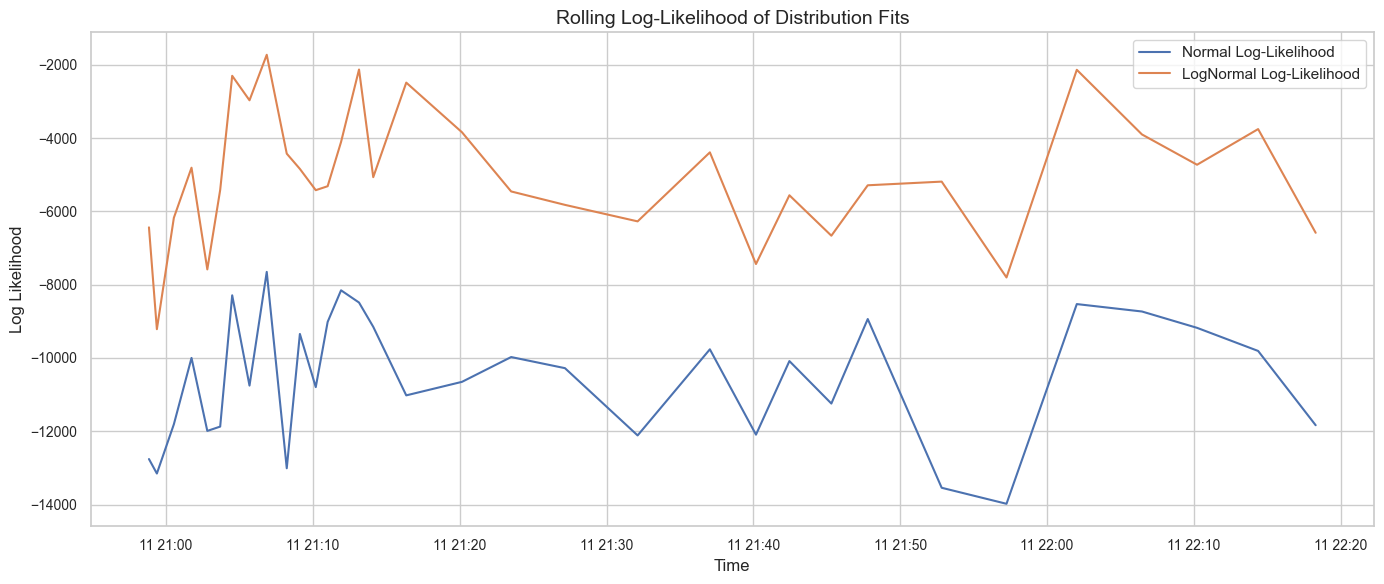

In [65]:

norm_lls = []
lognorm_lls = []
timestamps = []

for stat in rolling_stats:
    ts = stat["window_end"]
    timestamps.append(ts)
    
    norm_fit = stat["fits"].get("norm", {})
    lognorm_fit = stat["fits"].get("lognorm", {})

    norm_lls.append(norm_fit.get("log_likelihood", np.nan))
    lognorm_lls.append(lognorm_fit.get("log_likelihood", np.nan))


timestamps = np.array(timestamps)
norm_lls = np.array(norm_lls)
lognorm_lls = np.array(lognorm_lls)


mask = ~np.isnan(norm_lls) & ~np.isnan(lognorm_lls)
timestamps = timestamps[mask]
norm_lls = norm_lls[mask]
lognorm_lls = lognorm_lls[mask]


plt.figure(figsize=(14, 6))
plt.plot(timestamps, norm_lls, label="Normal Log-Likelihood")
plt.plot(timestamps, lognorm_lls, label="LogNormal Log-Likelihood")
plt.title("Rolling Log-Likelihood of Distribution Fits")
plt.xlabel("Time")
plt.ylabel("Log Likelihood")
plt.legend()
plt.tight_layout()
plt.show()



## Conclusion: Statistical Model Fit for Average Ask Volume Distributions

### Objective:

To assess the distributional structure of average ask volumes on a rolling basis, we performed maximum liklihood estimations comparisons between the Normal and Log-Normal distributions using high-frequency order book data.

### Methodology:

- Data was segmented into fixed-size rolling windows, overlapping
- log_avg_ask_volume was taken for each window
- Both normal and log-normal distributions were fit using scipy.stats MLE functions
- log-liklihood of observed data under each distribution was found
- visualized as time series to compare model performance

### Findings:

- Across all windows, the log-normal distribution consistently had higher log-liklihood values than the normal
- Both curves had similar shape showing sensitivity to the same structural shifts in the order book, log normal stayed closer to zero showing better fit.
- In many windows log-liklihood between normal and log-normal exceeded 4,000 to 8,000 points, which is statistically significant
- Strong indication that ask volume is positively skewed and heavy-tailed, violating Gaussian symetry model.

### Conclusion:
Results show strong evidence that log-normal distribution is a significantly better fit for modeling average ask volume in this market microstructure context. This exemplifies a statisical regularity often attributed to human rationality and bounded intelligence- one that persistently emerges across diverse asset market microstructure.